In [662]:
import tensorflow
from U_Net_D import unet, dice_loss, get_data
from tensorflow.keras.optimizers import Adam

tensorflow.debugging.set_log_device_placement(True)

In [663]:
adam = Adam(learning_rate=1e-3)
img_row = 256
img_col = 256
img_chan = 1
input_size = (img_row, img_col, img_chan)

In [664]:
model = unet(adam, input_size, dice_loss)

In [665]:
model_path = "../model/model-T_unet-maproad-fc2d.weights.h5"
model.load_weights(model_path)

In [666]:
path_test = '../training_dataset/tianditu/test/'
X_test, y_test = get_data(path_test, train=True)

Getting and resizing images ... 
Done!


In [667]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 273ms/step


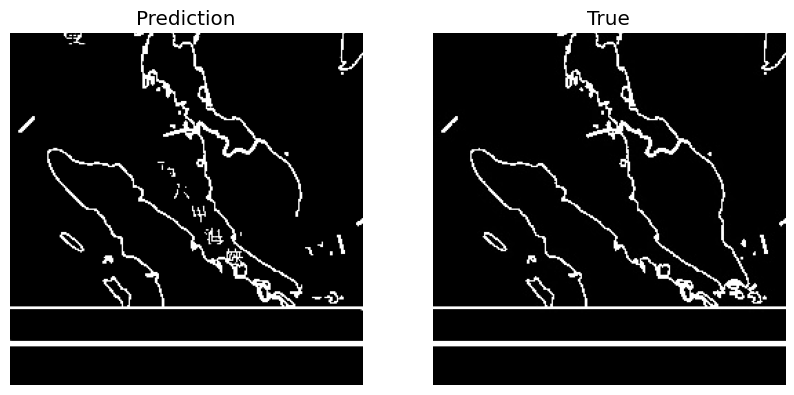

In [668]:
import matplotlib.pyplot as plt

for i in range(1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 15))
    ax[0].imshow(y_pred[i].squeeze(), cmap="gray")
    ax[0].set_title("Prediction")

    ax[1].imshow(y_test[i].squeeze(), cmap="gray")
    ax[1].set_title("True")

    for a in ax:
        a.axis("off")

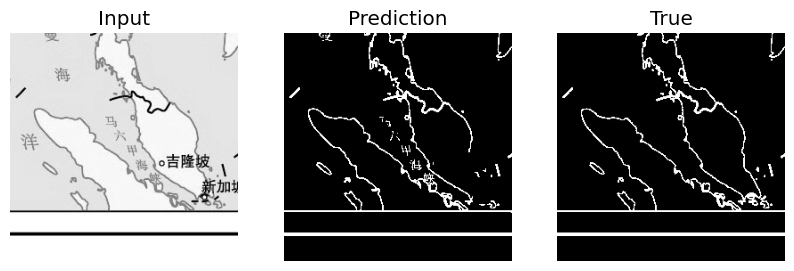

In [669]:
# Plot prediction, true and input image
import matplotlib.pyplot as plt

for i in range(1):
    fig, ax = plt.subplots(1, 3, figsize=(10, 15))
    ax[0].imshow(X_test[i].squeeze(), cmap="gray")
    ax[0].set_title("Input")

    ax[1].imshow(y_pred[i].squeeze(), cmap="gray")
    ax[1].set_title("Prediction")

    ax[2].imshow(y_test[i].squeeze(), cmap="gray")
    ax[2].set_title("True")

    for a in ax:
        a.axis("off")

In [670]:
# load image example3.png
# split it into 256x256 patches
# predict the patches
# reconstruct the image

In [671]:
from tensorflow.keras.preprocessing.image import load_img

In [672]:
img = load_img('../training_dataset/tianditu/test/images/0.jpg')

In [673]:
import numpy as np

from tensorflow.keras.utils import img_to_array
from skimage.transform import resize

train = False
X = np.zeros((40, 256, 256, 1), dtype=np.float32)

print('Getting and resizing images ... ')
x_img = img_to_array(img)
x_img = resize(x_img, (256, 256, 1), mode='constant', preserve_range=True)

X[0, ..., 0] = x_img.squeeze() / 255

print('Done!')

Getting and resizing images ... 
Done!


In [674]:
from tqdm import tqdm_notebook
import os

im_height = 256
im_width = 256

X = np.zeros((1, 256, 256, 1), dtype=np.float32)
if train:
    y = np.zeros((1, im_height, im_width, 1), dtype=np.float32)
img = load_img('../training_dataset/tianditu/test/images/0.jpg')
x_img = img_to_array(img)
x_img.shape

(256, 256, 3)

In [675]:
x_img = resize(x_img, (256, 256, 1), mode='constant', preserve_range=True)

X[0, ..., 0] = x_img.squeeze() / 255

In [676]:
x_img.shape

(256, 256, 1)

In [677]:
img = load_img('../training_dataset/tianditu/test/custom/col.png')
img = img_to_array(img)
img = resize(img, (256, 256, 1), mode='constant', preserve_range=True)
X = np.zeros((1, 256, 256, 1), dtype=np.float32)
X[0, ..., 0] = img.squeeze() / 255

In [678]:
X.shape

(1, 256, 256, 1)

In [679]:
# split the image into 256x256 patches
pred = model.predict(X, verbose=1)

1/1 [==============================] - 0s 15ms/step


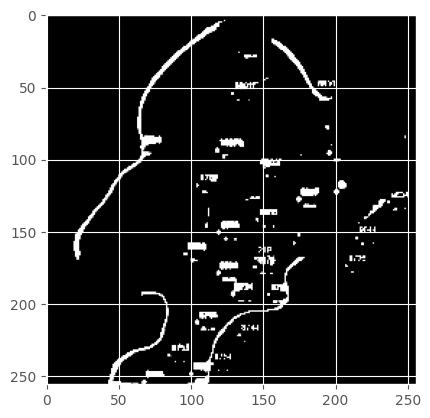

In [680]:
plt.imshow(pred[0].squeeze(), cmap="gray")

In [681]:
def split_image(img, patch_size):
    patches = []
    x_count = img.shape[0] // patch_size
    y_count = img.shape[1] // patch_size
    for i in range(x_count):
        for j in range(y_count):
            patch = img[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            patches.append(patch)
    result = np.array(patches)
    return result

In [682]:
def reconstruct_image(patches, img_shape):
    x_count = img_shape[0] // 256
    y_count = img_shape[1] // 256
    img = np.zeros(img_shape)
    for i in range(x_count):
        for j in range(y_count):
            img[i * 256:(i + 1) * 256, j * 256:(j + 1) * 256] = patches[i * y_count + j]
    return img

In [683]:
# make X from array of patches
def make_X(patches):
    patches = resize(patches, (len(patches), 256, 256, 1), mode='constant', preserve_range=True)
    X = np.zeros((len(patches), 256, 256, 1), dtype=np.float32)
    for i in range(len(patches)):
        X[i, ..., 0] = patches[i].squeeze() / 255
    return X

1/1 [==============================] - 0s 16ms/step


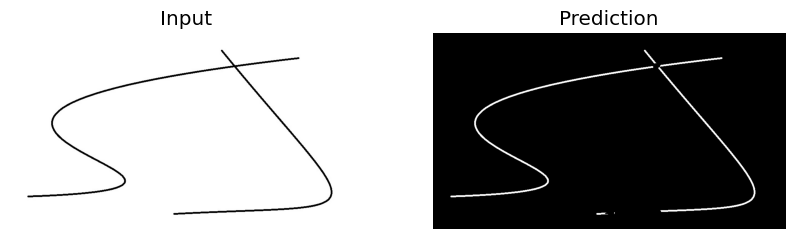

In [708]:
from PIL import ImageOps

reconstructed_img = None


def predict_image(img_path, model):
    global reconstructed_img
    patch_size = 256
    img = load_img(img_path)
    
    original_size = img.size
    
    x_patch_count = -(-img.size[0] // patch_size)
    y_patch_count = -(-img.size[1] // patch_size) 
    
    img = ImageOps.expand(img, (0, 0, patch_size - img.size[0] % patch_size, patch_size - img.size[1] % patch_size), fill="white")
    
    img = img_to_array(img)

    patches = split_image(img, patch_size)

    X = make_X(patches)

    pred_patches = model.predict(X)

    reconstructed_img = reconstruct_image(pred_patches, img.shape)
    # Rescale it to 0-255
    reconstructed_img = (reconstructed_img - np.min(reconstructed_img)) / (
            np.max(reconstructed_img) - np.min(reconstructed_img)) * 255

    reconstructed_img = reconstructed_img[:original_size[1], :original_size[0]]
    img = img[:original_size[1], :original_size[0]]

    fig, ax = plt.subplots(1, 2, figsize=(10, 15))
    fig.set_facecolor("white")
    ax[0].imshow(img.astype(np.uint8), cmap="gray", vmin=0, vmax=255)
    ax[0].set_title("Input")
    ax[1].imshow(reconstructed_img.astype(np.uint8), cmap="gray", vmin=0, vmax=255)
    ax[1].set_title("Prediction")  

    for a in ax:
        a.axis("off")
predict_image('../training_dataset/tianditu/test/custom/Screenshot_1.jpg', model)

In [686]:
#plot the patches
# fig, ax = plt.subplots(1, X.shape[0], figsize=(10, 15))
# for i in range(X.shape[0]):
#     im = X[i].squeeze()
#     im = (im - np.min(im)) / (np.max(im) - np.min(im)) * 255
#     ax[i].imshow(im, cmap="gray", vmin=0, vmax=255)
#     ax[i].axis("off")